# EDA and LGMB Baseline 📚🤖📊

#### Please give an upvote if you find this useful! (WIP)

### Imports 🗂

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm import tqdm

import seaborn as sns
from scipy.stats import pearsonr
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

### Load in the data ⏳
Load in the pickle file from https://www.kaggle.com/columbia2131/speed-up-reading-csv-to-pickle :)

In [11]:
DATA_PATH = Path('../input/ump-train-picklefile')
SAMPLE_TEST_PATH = Path('../input/ubiquant-market-prediction')
!ls $SAMPLE_TEST_PATH

example_sample_submission.csv  example_test.csv  train.csv  ubiquant


In [12]:
train = pd.read_pickle(DATA_PATH/'train.pkl')

### Basic EDA 📊

In [13]:
train.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


We can see each data point has:

- `row_id` - A unique identifier for the row

- `time_id` - ID for the time the data was collected. Not all investments have data for all the time IDs

- `investment_id` - ID for each individual investment

- `target` - The target

- `[f_0:f_299]` - features generated from the investment data at that time ID

In [14]:
num_data_points = len(train)
print(f'We have {num_data_points} data points')

We have 3141410 data points


In [15]:
num_investments = train['investment_id'].nunique()
print(f'We have {num_investments} unique investments')

We have 3579 unique investments


In [16]:
num_time_intervals = train['time_id'].nunique()
print(f'Each investment has a maximum of {num_time_intervals} time intervals')

Each investment has a maximum of 1211 time intervals


(Note this seems to disagree with the summary statistics in the data tab of the competition..)

### Target and Time_id distribution

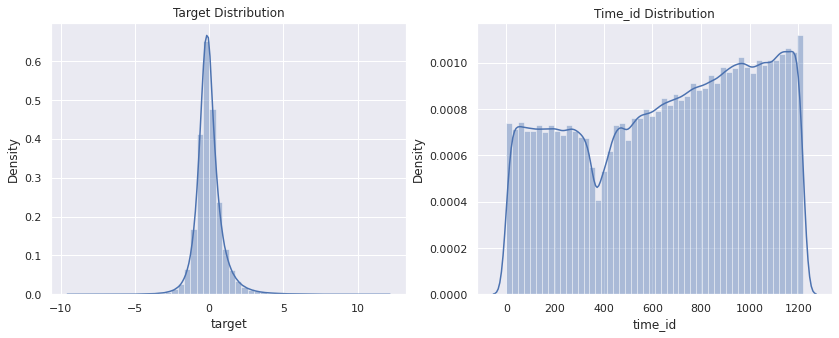

In [17]:
sns.set_theme()
fig, ax =plt.subplots(1,2, figsize=(14, 5))
sns.distplot(train['target'], ax=ax[0]).set_title('Target Distribution')
sns.distplot(train['time_id'], ax=ax[1]).set_title('Time_id Distribution')
fig.show()

### Target distribution of investment 0, 1 and 2


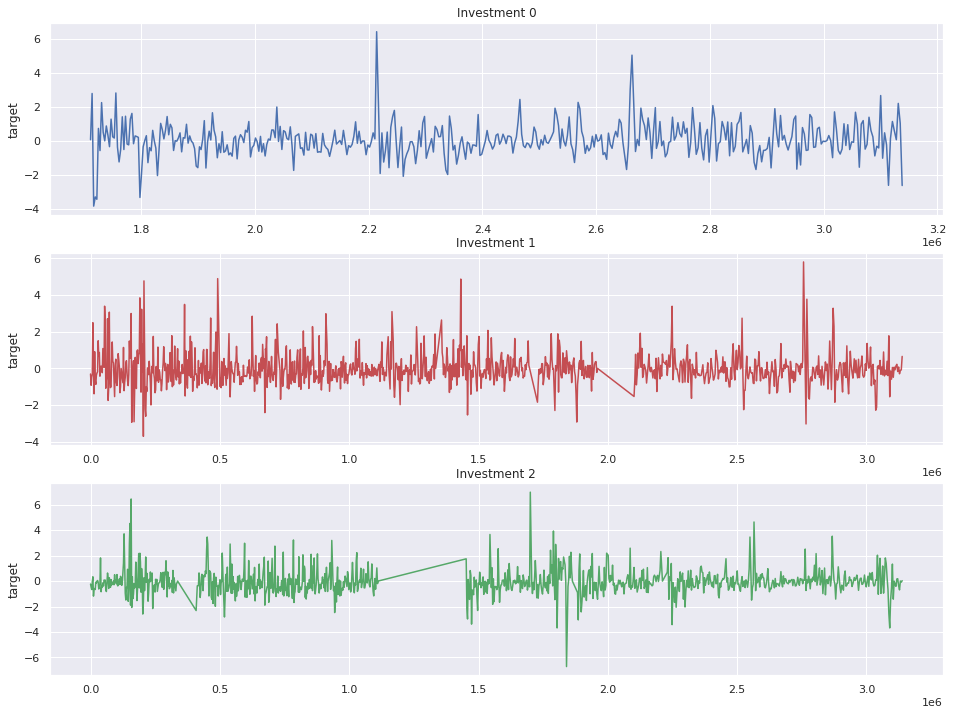

In [18]:
sns.set_theme()
fig, ax =plt.subplots(3,1, figsize=(16, 12))
sns.lineplot(data=train[train['investment_id']==0]['target'], ax=ax[0]).set_title('Investment 0')
sns.lineplot(data=train[train['investment_id']==1]['target'], ax=ax[1], color='r').set_title('Investment 1')
sns.lineplot(data=train[train['investment_id']==2]['target'], ax=ax[2], color='g').set_title('Investment 2')
fig.show()

#### Looking at correlation between the first 30 anonymous features, time_id and target for investment 0

<AxesSubplot:>

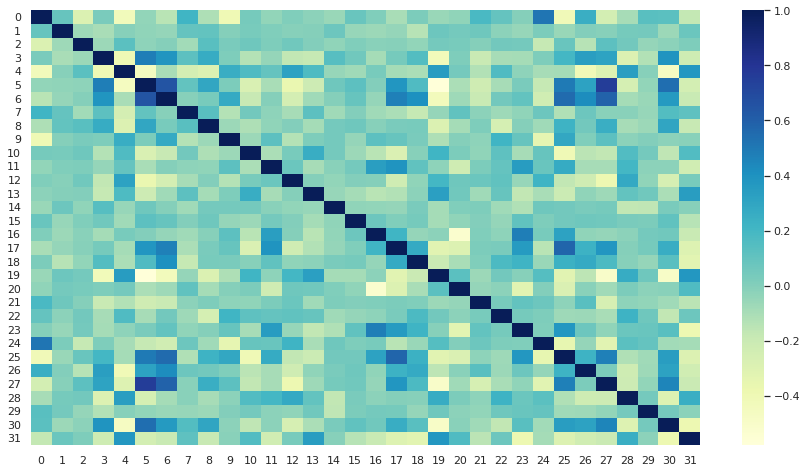

In [19]:
investment_0 = train[train['investment_id']==0]
df = investment_0.drop(['row_id', 'investment_id'], axis=1)
del investment_0
df_30 = df.iloc[: , :32]
del df
corrMatrix = df_30.corr()
plt.figure(figsize = (15,8))
sns.heatmap(corrMatrix.to_numpy(), cmap="YlGnBu")

### Basic LightGBM model for investment 0, 1 and 2 🌳

In [4]:
train.drop(['row_id', 'time_id'], axis=1, inplace=True)
X = train.drop(['target'], axis=1)
y = train["target"]
del train
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)
del X
del y

In [5]:
model = LGBMRegressor(
        objective="regression",
        metric="rmse",
        boosting_type="gbdt",
        n_estimators=1400,
        num_leaves=100,
        max_depth=10,
        learning_rate=0.05,
        subsample=0.8
)

model.fit(X_train, y_train,
          eval_set=[(X_valid, y_valid)],
          verbose=2,
          eval_metric='rmse',
          early_stopping_rounds=400)


[50]	valid_0's rmse: 0.896574


LGBMRegressor(learning_rate=0.05, max_depth=10, metric='rmse',
              n_estimators=1400, num_leaves=100, objective='regression',
              subsample=0.8)

In [6]:
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

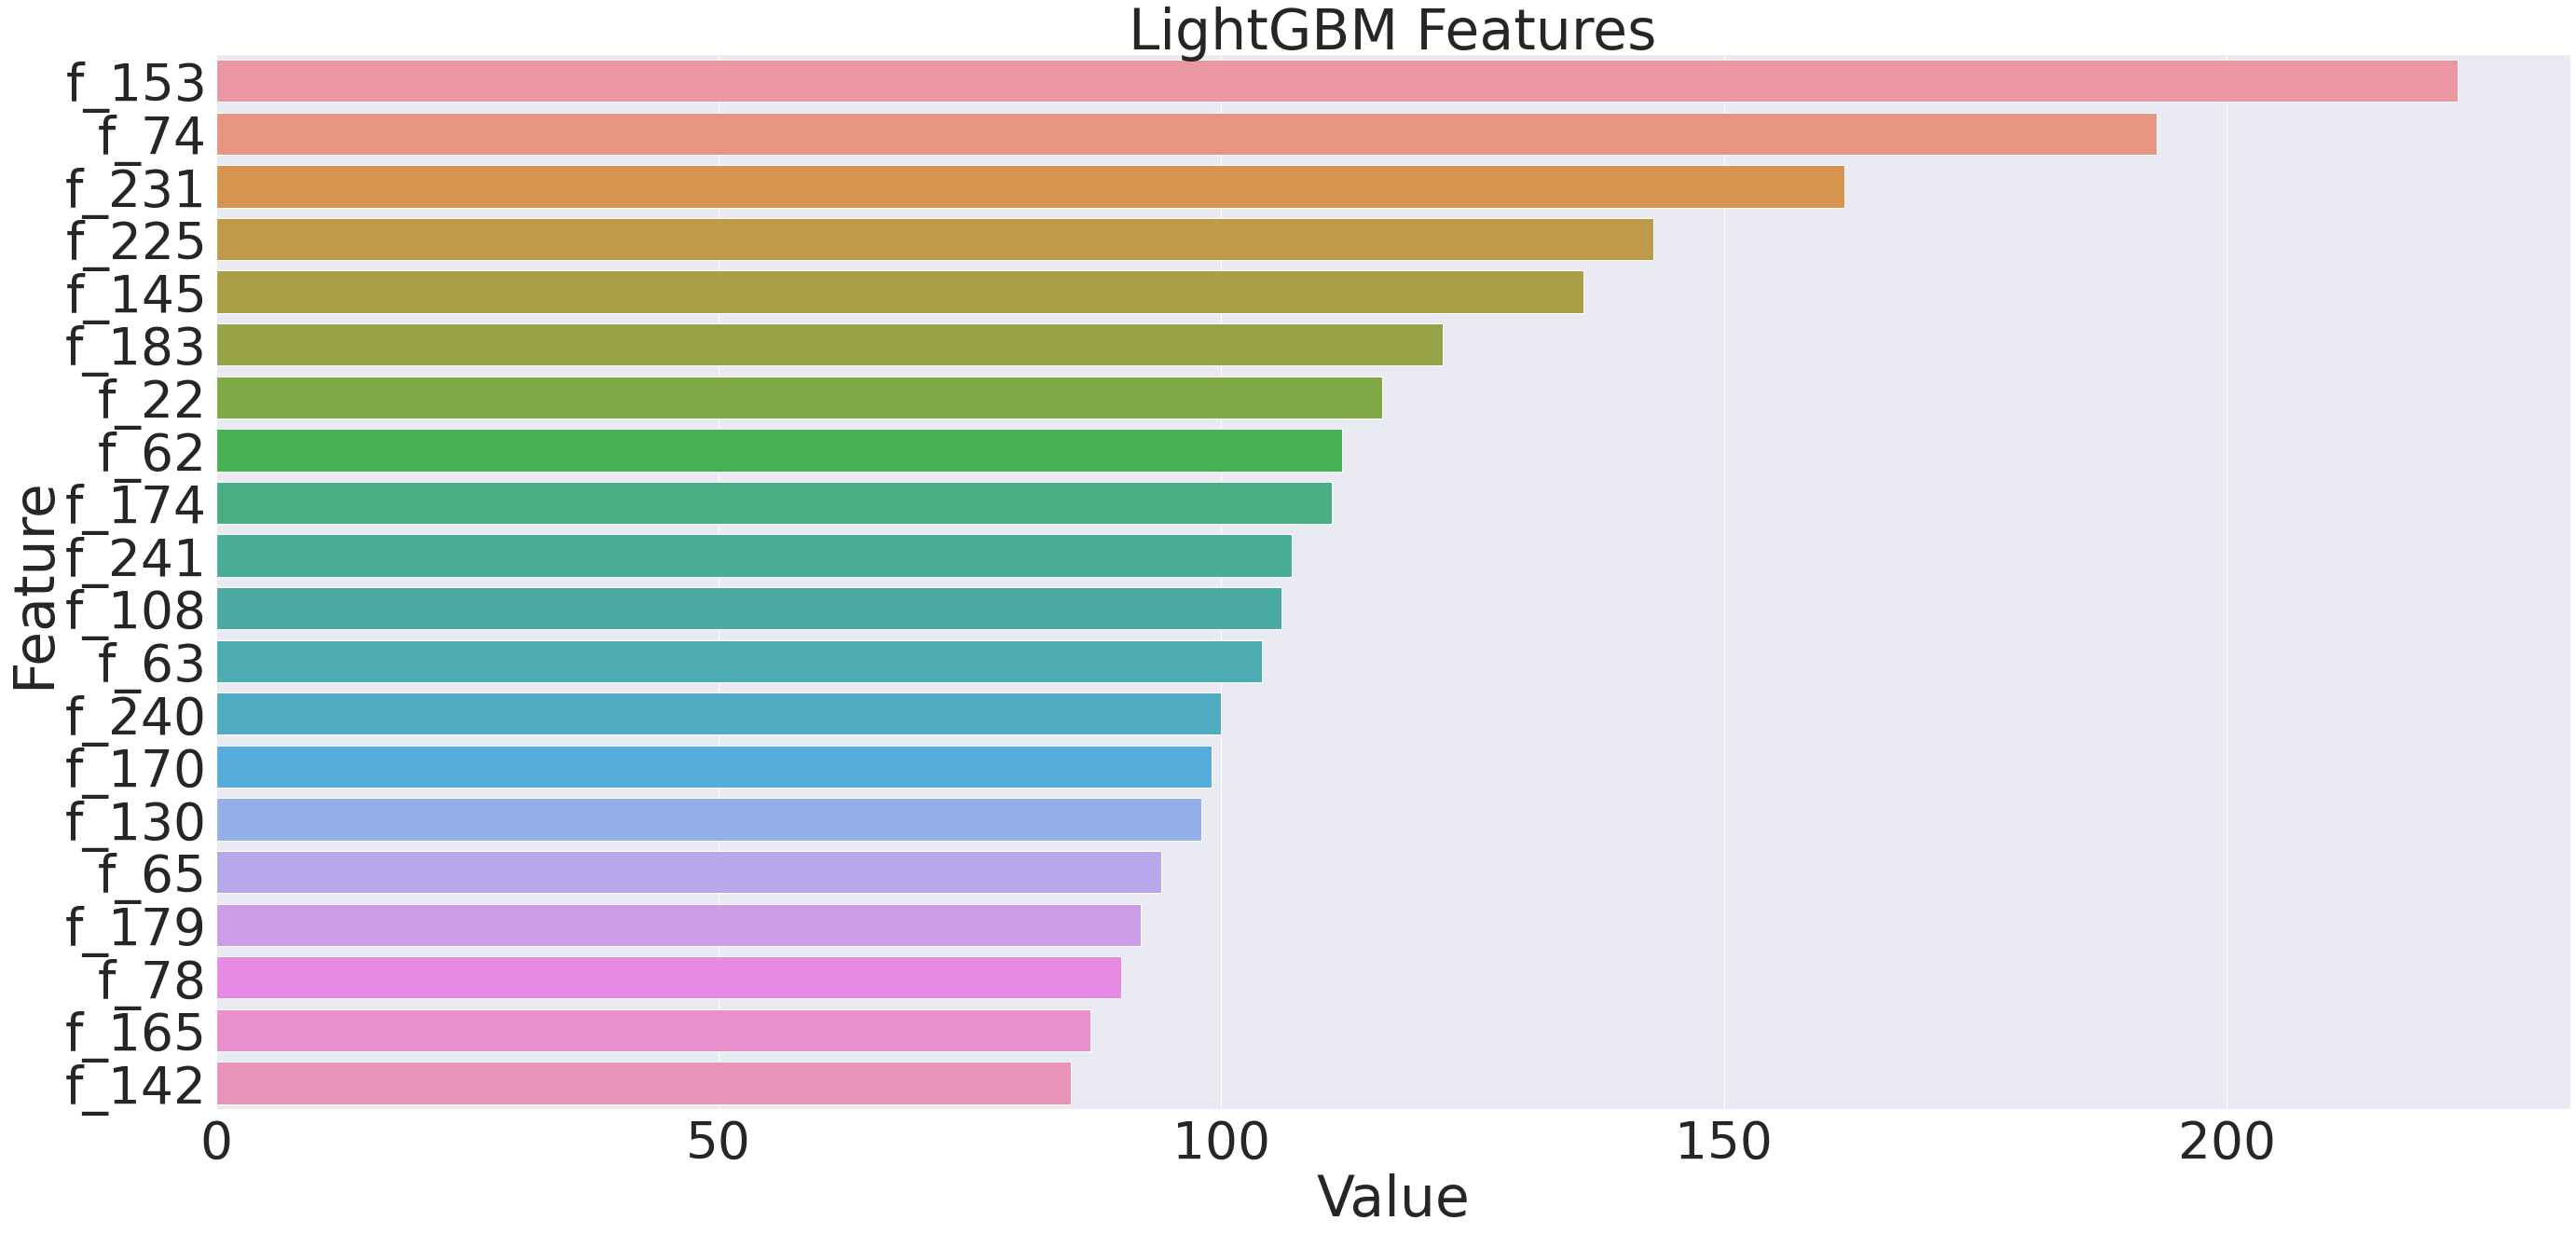

In [7]:
plotImp(model, X_valid)

In [ ]:
#### Code for kfold split. This can't run on a kaggle kernel due to memory limits ####

#n_splits = 4
#kf = KFold(n_splits=n_splits, shuffle=True)
#models = []
#for i, (train_index, test_index) in enumerate(kf.split(X, y)):
#    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
#    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
#    
#    model = LGBMRegressor(
#        objective="regression",
#        metric="rmse",
#        boosting_type="gbdt",
#    )
#    
#    model.fit(X_train, y_train,eval_set=[(X_valid, y_valid)], 
#            early_stopping_rounds=100)
#    models.append(model)
#    
#    print(f'Trained {i}/{n_splits} models')

#### Look at sample submission and example test csvs



In [8]:
example_test = pd.read_csv(SAMPLE_TEST_PATH/'example_test.csv')
sample_sub = pd.read_csv(SAMPLE_TEST_PATH/'example_sample_submission.csv')
display(example_test.head(2))
display(sample_sub.head(2))

,row_id,time_id,investment_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,1220_1,1220,1,0.874944,0.457875,0.962572,0.372061,0.004509,0.971304,0.097477,...,0.514031,0.828523,0.437697,0.810764,0.693963,0.186403,0.569144,0.120386,0.419603,0.936966
1,1220_2,1220,2,0.554862,0.445478,0.714034,0.891988,0.703331,0.264478,0.600636,...,0.620919,0.301540,0.687464,0.400168,0.908198,0.272901,0.222430,0.748324,0.858802,0.362829


,row_id,time_id,target
0,1220_1,1220,0
1,1220_2,1220,0


In [9]:
import ubiquant
env = ubiquant.make_env()  
iter_test = env.iter_test()
for (test_df, sample_prediction_df) in iter_test:
    test_df.drop(['row_id'], axis=1, inplace=True)
    pred = model.predict(test_df)
    sample_prediction_df['target'] = pred
    env.predict(sample_prediction_df) 

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
